# Apartment cost forecasting system
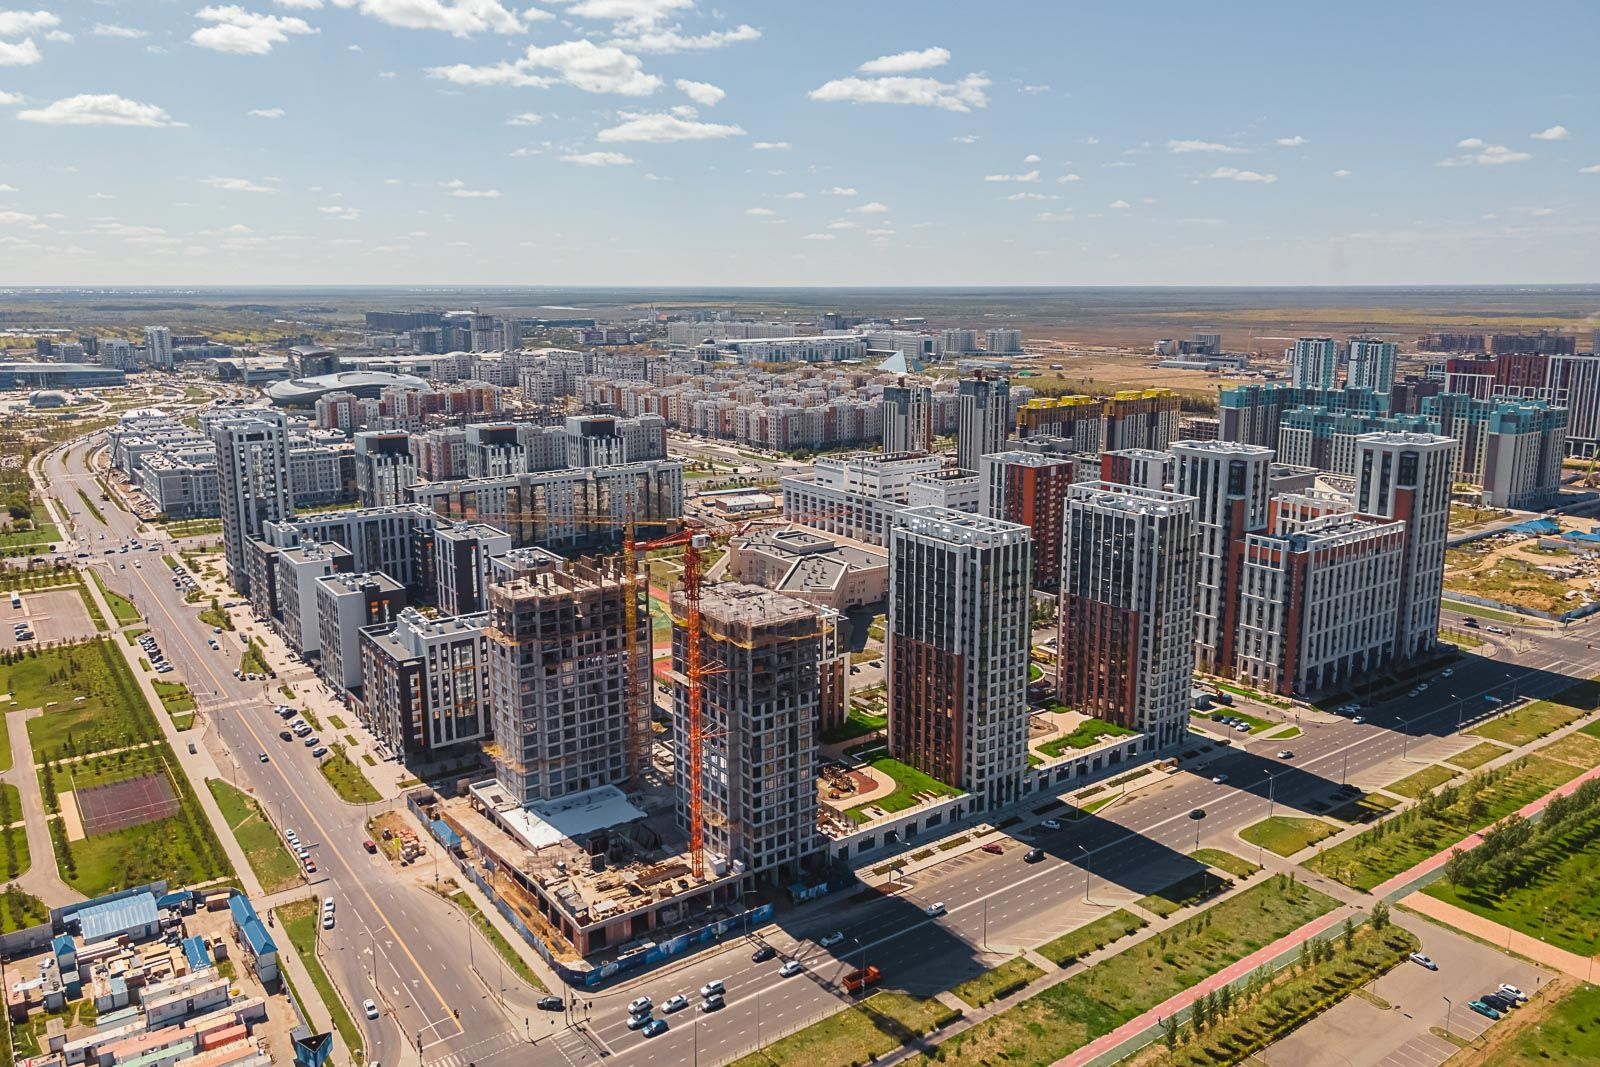

The main goal of this project is to develop apartment's cost forecasting system. 


For downloading and visualizing data I'm using libriries below: pandas - for downloading, from matplolib sublib 'pyplot' and seabon - for visualization

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import math
import json

from scipy.stats import shapiro


# Downloading data

In [134]:
data = pd.read_csv('/home/gor/Desktop/Price_house_prediction_system/data.csv/data.csv')
data.head()

status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   
3          Dallas  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...   
4        Palm Bay  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   
3  6,457 sqft   75205  5 Beds    TX     3.0    NaN         NaN    14191809   
4         NaN   32908     NaN    FL     NaN    NaN         NaN      861745   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000  
3  $2,395,000  
4      $5,000

# Exploratory data analysis

## Common data research

Drop rows with None-values in target-feature

In [135]:
data.dropna(axis=0, subset=['target'], inplace=True)

Looking for empty values in other features.

In [136]:
for i in data.columns:
    print(data[i].isna().value_counts())

False    335447
True      39257
Name: status, dtype: int64
True     370553
False      4151
Name: private pool, dtype: int64
False    340150
True      34554
Name: propertyType, dtype: int64
False    374702
True          2
Name: street, dtype: int64
False    269328
True     105376
Name: baths, dtype: int64
False    374704
Name: homeFacts, dtype: int64
True     272182
False    102522
Name: fireplace, dtype: int64
False    374670
True         34
Name: city, dtype: int64
False    374704
Name: schools, dtype: int64
False    334582
True      40122
Name: sqft, dtype: int64
False    374704
Name: zipcode, dtype: int64
False    283748
True      90956
Name: beds, dtype: int64
False    374704
Name: state, dtype: int64
False    224910
True     149794
Name: stories, dtype: int64
True     349767
False     24937
Name: mls-id, dtype: int64
True     334583
False     40121
Name: PrivatePool, dtype: int64
False    310226
True      64478
Name: MlsId, dtype: int64
False    374704
Name: target, dtype: int64


To continue exploration I should get an integer values from target-feature

In [137]:
def get_price(data_string):
    """ Function return integer value from string """

    value_list = re.findall(r'[0-9]+', data_string)
    string_value = ''.join(value_list)
    return int(string_value)


data['price'] = data.target.apply(get_price)
data.drop('target', axis=1, inplace=True)

## Status

<Axes: xlabel='zipcode', ylabel='price'>

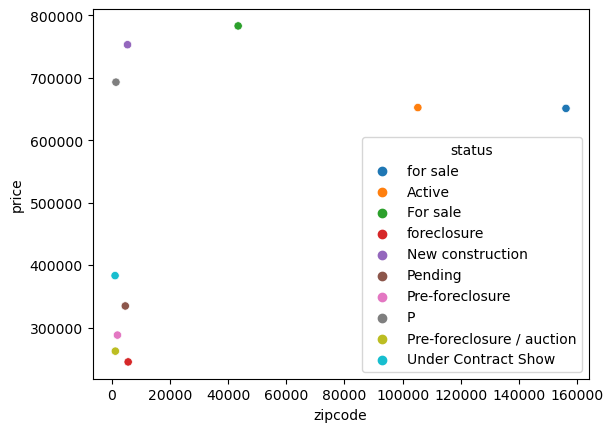

In [138]:
grouped_status = data.groupby('status', as_index=False)[['price', 'zipcode']]\
    .agg({'price':'mean', 'zipcode':'count'})\
    .sort_values(by=['zipcode', 'price'], ascending=False)

sns.scatterplot(
    data = grouped_status.iloc[:10],
    x='zipcode',
    y='price',
    hue='status'
)

As we can see there are three the most numerous group of statuses: for sale, Active and For sale. They mean the same things that's why I will union them into one group.
The next group I'll choose 

In [139]:
top_status1 = grouped_status.status.iloc[:3].tolist()
top_status2 = grouped_status.status.iloc[3:10].tolist()

def group_status(status):

    """ Function will return value which group 
    each status belongs to """

    if status in top_status1:
        return 'group1'
    
    elif status in top_status2:
        return 'group2'
        
    else:
        return 'other'

data.status = data.status.apply(group_status)

I separated all statuses into three groups. Let's look at new distribution.

<Axes: xlabel='zipcode', ylabel='price'>

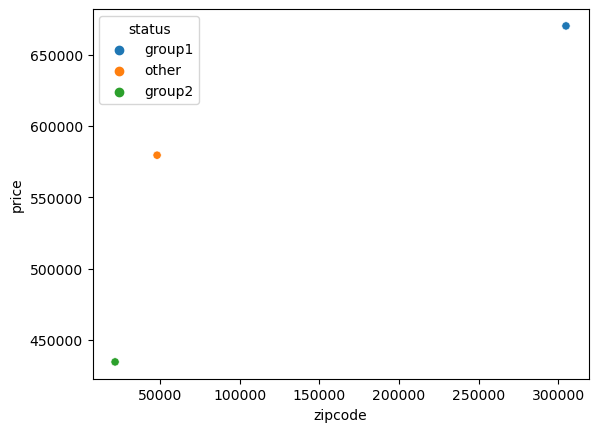

In [140]:
grouped_status = data.groupby('status', as_index=False)[['price', 'zipcode']]\
    .agg({'price':'mean', 'zipcode':'count'})\
    .sort_values(by=['zipcode', 'price'], ascending=False)

sns.scatterplot(
    data = grouped_status.iloc[:10],
    x='zipcode',
    y='price',
    hue='status'
)

## Pool

Let's make categorical data from 'private pool' feature: True - if in house there is a pool, False - if no.

In [141]:
data['private pool'] = data['private pool'].apply(lambda x: True if isinstance(x, str) else False)
data.PrivatePool = data.PrivatePool.apply(lambda x: True if isinstance(x, str) else False)

# Make bitwise-or to get the pool value
private_pool = data['private pool'] | data.PrivatePool
# Transform True into 1, False - 0 for further data processing
data['private_pool'] = private_pool.apply(lambda x: 1 if x is True else 0)
# Drop unuseful features
data.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)

Let's look at relationship between pools and prices for houses. We can suppose that if there is in house pool it will be more expensive.

<Axes: xlabel='private_pool', ylabel='price'>

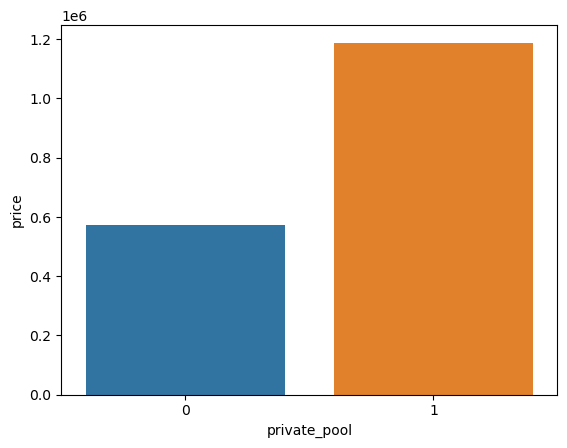

In [142]:
mean_price_per_pool = data[['price', 'private_pool']].groupby('private_pool', as_index=False)['price'].mean()
sns.barplot(
    mean_price_per_pool, 
    x='private_pool', 
    y='price'
    )

## Property type

/tmp/ipykernel_5034/1282255561.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  price_property = data.groupby('propertyType', as_index=False)['price', 'zipcode']\


<Axes: xlabel='zipcode', ylabel='price'>

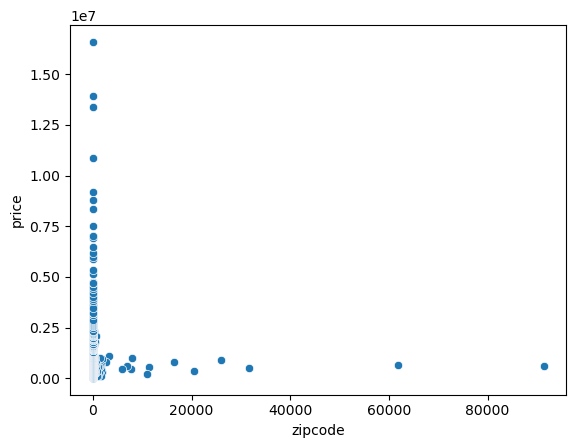

In [143]:
price_property = data.groupby('propertyType', as_index=False)['price', 'zipcode']\
    .agg({'price':'mean', 'zipcode':'count'})\
    .sort_values(by=['zipcode', 'price'], ascending=[False, True])

price_property.iloc[:10]

sns.scatterplot(
    data=price_property,
    x='zipcode',
    y='price'
)

Researched data I decided to separate property type into 3 groups.

In [144]:
property_group1 = price_property.propertyType.iloc[:3].tolist()
property_group2 = price_property.propertyType.iloc[3:8].tolist()

def get_property(prop):
    """" Function returns name of group 
    which each property type belongs to """

    if prop in property_group1:
        return 'prop1'
    
    elif prop in property_group2:
        return 'prop2'

    else:
        return 'prop3'


data.propertyType = data.propertyType.apply(get_property)

/tmp/ipykernel_5034/3137335718.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  price_property = data.groupby('propertyType', as_index=False)['price', 'zipcode']\


<Axes: xlabel='zipcode', ylabel='price'>

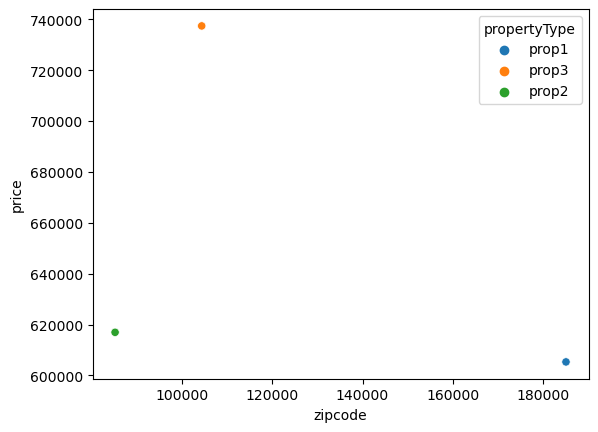

In [145]:
price_property = data.groupby('propertyType', as_index=False)['price', 'zipcode']\
    .agg({'price':'mean', 'zipcode':'count'})\
    .sort_values(by=['zipcode', 'price'], ascending=[False, True])

price_property.iloc[:10]

sns.scatterplot(
    data=price_property,
    x='zipcode',
    y='price',
    hue='propertyType'
)

## Street

In [146]:
abbrev_list = ['st', 'ave', 'ln', 'rd', 'ct', 'dr', 'cir', 'blvd', 'pl', 'plz']

As we know, house numering in US is different from Russia. I pass all explanations about and note that to know where house is located in the street we need two last numbers in address. Explanation: if number is close to 0 or 100 we can say that house locates at the beggining or end of street, respectively. If number close to 50 that means that house locates in the middle of street.

In [147]:
def get_num_type(address):

    """ Function returns type of street and 
    last two numbers of number-part of address """

    st_type = 'other'
    num = 0
    
    address = str(address)
    addr_list = address.lower().split(' ')
    
    for i in addr_list:

        if i in abbrev_list:
            st_type = i

        elif i.isdigit():
            num = int(i[-2:])

    return st_type, num

type_num = data.street.apply(get_num_type)
# Extract data to dataset
data['street_type'] = type_num.apply(lambda x: x[0])
data['house_loc'] = type_num.apply(lambda x: x[1])

# Replace pl to plz because those values are same
data.street_type = data.street_type.apply(lambda x: 'plz' if x=='pl' else x)

Let's look how price depends from type of street where house's located.

<Axes: xlabel='street_type', ylabel='price'>

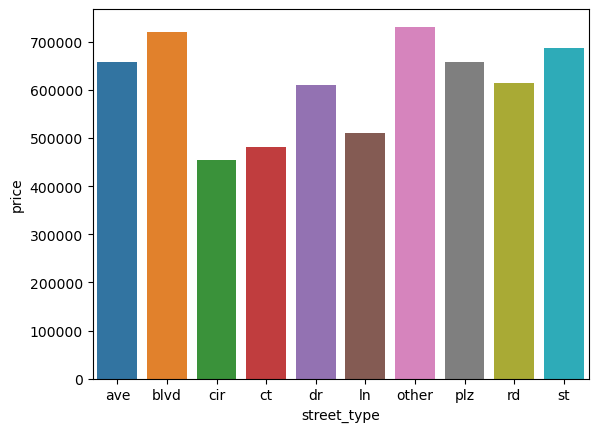

In [148]:
price_per_street_type = data.groupby('street_type', as_index=False)['price'].mean()
sns.barplot(
    data=price_per_street_type,
    x='street_type',
    y='price'
)

Looking at the plot I can conclude that price is depending in which type of street house is located.

Next step - research how price depends from house location in the street. At first, we should split all values of house location to 5 zones: from 0 to 10 plus from 20 to 30 plus from 80 to 90, etc.

In [149]:
def zone_splitter(zone):

    if zone in range(0, 11) or zone in range(91, 101):
        return 'zone1'
    
    elif zone in range(11, 21) or zone in range(81, 91):
        return 'zone2'

    elif zone in range(21, 31) or zone in range(71, 81):
        return 'zone3'

    elif zone in range(31, 41) or zone in range(61, 71):
        return 'zone4'

    else:
        return 'zone5'
    

data['street_zone'] = data.house_loc.apply(zone_splitter)

<Axes: xlabel='street_zone', ylabel='price'>

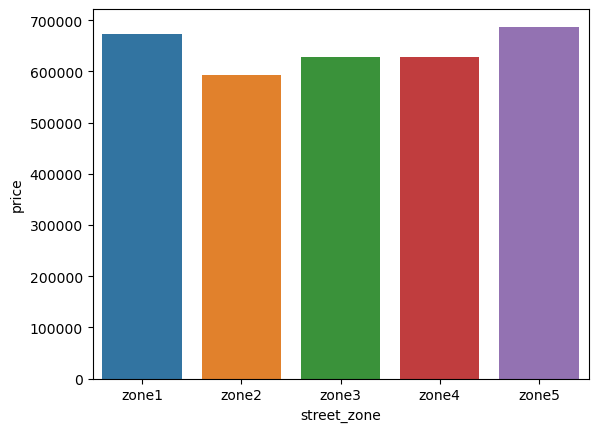

In [150]:
price_per_num_location = data.groupby('street_zone', as_index=False)['price'].mean()
sns.barplot(
    data=price_per_num_location,
    x='street_zone',
    y='price'
)

In [151]:
data.drop(['house_loc', 'street'], axis=1, inplace=True)

## Baths

In [152]:
def get_baths_num(bath):
    """ Function returns number of baths
    and marker is there half or quarter bath """

    if isinstance(bath, str):

        f_list = re.findall('\d+', bath)

        if len(f_list) == 1:
            nums = int(f_list[0])

            if nums>100:
                return [0, f_list[0]]

            else:
                return [f_list[0], 0]

        elif len(f_list) == 2:
            return [f_list[0], f_list[1]]

        else:
            return [0, 0]

    else:
        return [0, 0]

num_baths = data.baths.apply(get_baths_num)
# Extracting number of full-type baths and additional baths into separate features
data['num_baths'] = num_baths.apply(lambda x: int(x[0]))
data['additional_bath'] = num_baths.apply(lambda x: int(x[1]))
data.drop('baths', axis=1, inplace=True)



In [153]:
def addition_bath_check(bath):
    """ Function returns number of size of additional bath """
    if bath<10:
        return bath/10

    elif bath>=10 and bath<100:
        return bath/100
    
    elif bath>=100:
        return bath/1000

data.additional_bath = data.additional_bath.apply(addition_bath_check)
data.additional_bath = data.additional_bath.apply(lambda x: x if x>0.25 else 0.25)

<Axes: xlabel='num_baths', ylabel='price'>

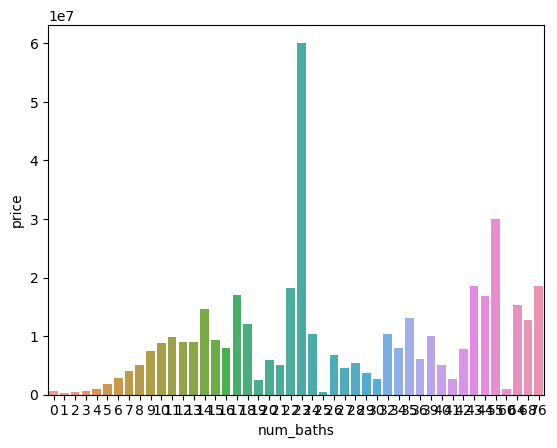

In [154]:
price_per_num_baths = data.groupby('num_baths', as_index=False)['price'].mean()
sns.barplot(
    data=price_per_num_baths,
    x='num_baths',
    y='price'
)

<Axes: xlabel='additional_bath', ylabel='price'>

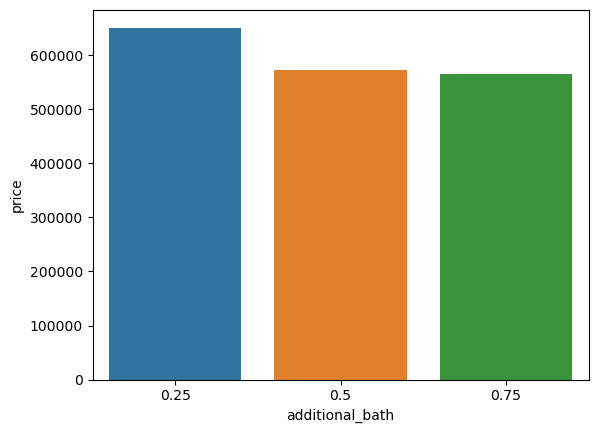

In [155]:
price_per_additional_bath = data.groupby('additional_bath', as_index=False)['price'].mean()
sns.barplot(
    data=price_per_additional_bath,
    x='additional_bath',
    y='price'
)

## Home Facts

In [156]:
#home_facts = data.homeFacts.apply(lambda x: eval(x)['atAGlanceFacts'])
#facts_df = pd.DataFrame()
#
#for i in home_facts:
#
#    line = (pd.DataFrame(i).set_index('factLabel')).transpose()
#    facts_df = pd.concat(
#        [facts_df, line],
#        axis=0
#    )
#facts_df.drop('Unnamed: 0', axis=1, inplace=True)

In [157]:
facts_df = pd.read_csv('/home/gor/Desktop/Price_house_prediction_system/facts_df.csv')
facts_df.drop('Unnamed: 0', axis=1, inplace=True)
facts_df.head()

Year built  Remodeled year                 Heating  Cooling  \
0       2019             NaN  Central A/C, Heat Pump      NaN   
1       2019             NaN                     NaN      NaN   
2       1961          1967.0              Forced Air  Central   
3       2006          2006.0              Forced Air  Central   
4        NaN             NaN                     NaN      NaN   

           Parking      lotsize Price/sqft  
0              NaN          NaN       $144  
1              NaN    5828 sqft  $159/sqft  
2  Attached Garage   8,626 sqft  $965/sqft  
3  Detached Garage   8,220 sqft  $371/sqft  
4              NaN  10,019 sqft        NaN

In [158]:
def get_built_year(year):
    """ Function returns whether there is
    information about house built year, if yes - value too """

    try:
        if math.isnan(year):
            return 0 
    
    except:
        if (year.isdigit() and int(year)<2023):

            return int(year)
        


        else:
            return 0


facts_df['Year built'] = facts_df['Year built'].apply(get_built_year)
# Doing same that with 'Year built' using lambda-function
facts_df['Remodeled year'].fillna(0, inplace=True)
# Extract information about heating in houses
facts_df.Heating = facts_df.Heating.fillna('no').apply(lambda x: False if x=='no' else True)

Допилить

In [159]:
def get_cooling_system(cool):
    """ Function returns 1 if there is cooling or heating system
    0 - if no and -1 if no data about such system """ 


    if cool.lower()=='none':
        return 0
    
    elif cool.lower()=='no data':
        return (-1)

    else:
        return 1


facts_df.Cooling = facts_df.Cooling.fillna('None').apply(get_cooling_system)


In [160]:
facts_df.Parking.value_counts().iloc[:25]

Attached Garage                     70244
2 spaces                            27867
1 space                             14109
Detached Garage                     13094
No Data                             13023
Carport                              7664
3 spaces                             4702
Off Street                           3601
Carport, Attached Garage             3006
1                                    2928
4 spaces                             2900
2                                    2745
None                                 2343
Off street                           1639
Attached Garage, Detached Garage     1334
On Street                            1237
0                                    1114
Attached Garage, Carport              987
Parking Desc                          900
6 spaces                              748
Detached Garage, Attached Garage      720
Driveway                              693
5 spaces                              654
4                                 

In [161]:
def get_parking_type(parking):

    """ Function returns a number of parking places
    and their type """

    number = 0
    type = []
    type_check = ''

    type_attached = ['attached', 'carport']
    type_detached = ['detached', 'on', 'off', 'desc']

    p_list = parking.lower().split(' ')

    if parking.lower() == 'no data':
        return (-1, 'unk')
    
    elif parking.isdigit():
        return (int(parking), 'unk')

    for i in p_list:

        i=i.strip(',')

        if i in type_attached:
            number+=1
            type.append('att')

        elif i in type_detached:
            number+=1
            type.append('det')

        elif i.isdigit():
            number=int(i)
            type.append('unk')

    if len(type)>=2:
        type_check='both'

    elif len(type)==1:
        type_check = type[0]

    elif len(type)==0:
        
        if number==0:
            type_check='no'
        
        else:
            type_check='unk'

    return (number, type_check)

facts_df.Parking = facts_df.Parking.astype('str')
parkings = facts_df.Parking.apply(get_parking_type)
facts_df['number_parkings'] = parkings.apply(lambda x: x[0])
facts_df['type_parkings'] = parkings.apply(lambda x: x[1])


Join extracted data with the main dataset

In [162]:
facts_df.drop(['Parking', 'lotsize', 'Price/sqft'], axis=1, inplace=True)

In [163]:
data = (data.reset_index(drop=True)).merge(
    right = facts_df.reset_index(drop=True),\
    left_index=True,\
    right_index=True,\
    how='inner')

data.drop('homeFacts', axis=1, inplace=True)

## Fireplace 

In [164]:
data.fireplace.value_counts().iloc[10:25]

Gas/Gas Logs                 300
No                           289
Fireplace YN                 287
Special Features             279
1 Fireplace                  274
0                            270
FAMILYRM                     246
Fireplace Features           239
Great Room                   207
Wood                         206
Gas Logs, Great Room         188
Ceiling Fan                  186
Living Room, Wood Burning    185
4                            184
Family Room, Wood Burning    149
Name: fireplace, dtype: int64

In [165]:
def get_fireplaces(fire):
    """" Function returns number and type of fireplace """

    fire = fire.lower()

    no_list = ['no', 'nan', 'none']
    type_list = ['wood', 'gas', 'electric']
    check_room = ['rm', 'room']

    number = 0
    type='unk'

    for i in fire.split(' '):
        i = i.strip(',')

        if i in no_list:
            return (number, 'no')

        elif i in type_list:
            type=i
        
        elif i in check_room or i=='yes':
            number+=1

        elif i.isdigit():
            number = int(i)
    
    return (number, type)

fireplaces = data.fireplace.astype('str').apply(get_fireplaces)
data['fireplace_num'] = fireplaces.apply(lambda x: x[0])
data['fireplace_type'] = fireplaces.apply(lambda x: x[1])
data.drop('fireplace', axis=1, inplace=True)

## Schools

In [166]:
def get_rating(r_list):
    """" Function processed a list of rating and return 
    average of clear values """

    out_rating = []

    for i in r_list:
        r = i.split('/')

        if r[0].isdigit():
            out_rating.append(int(r[0]))

        else:
            pass

    return round(np.mean(out_rating), 2)


def get_distance(dist):
    """" Function returns a list of distance values for
    each school """

    out_dist = []
    for i in re.findall('\d+.\d+', str(dist)):
        out_dist.append(float(i))

    return round(np.mean(out_dist), 2)


def get_school_type(names):
    
    """" Function return a list with marks if in the city
    there are schools of three types: elementary, middle, high """

    bag = ' '.join(names)
    bag = bag.lower()
    
    type_list = ['elementary', 'middle', 'high']

    types = [0, 0, 0]

    for i, val in enumerate(type_list):
        
        if val in bag:
            types[i] = 1

    return types

In [167]:
def get_school_info(f1, f2, f3):
    """ Funtion returns a tuple with school info such 
    as mean raiting for all schools in the city, average
    distance to school from house and city's school type """

    def get_info(inform):
        rating = inform['rating']
        distance = inform['data']['Distance']
        name = inform['name']
        return [f1(rating), f2(distance), f3(name)]

    return get_info

get_school_info = get_school_info(get_rating, get_distance, get_school_type)

In [168]:
# Transform data.schools into dictionary
data.schools = data.schools.apply(lambda x: eval(x)[0])
# Use function that will extract neсessary information
school_data = data.schools.apply(get_school_info)
# Make new features in dataframe
data['av_school_rating'] = school_data.apply(lambda x: x[0])
data['av_school_dist'] = school_data.apply(lambda x: x[1])
data['schools_type'] = school_data.apply(lambda x: x[2])
# Delete schools-feature
data.drop('schools', axis=1, inplace=True)

/home/gor/miniconda3/envs/condaDS/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [176]:
data.columns

Index(['status', 'propertyType', 'city', 'sqft', 'zipcode', 'beds', 'state',
       'stories', 'mls-id', 'MlsId', 'price', 'private_pool', 'street_type',
       'street_zone', 'num_baths', 'additional_bath', 'Year built',
       'Remodeled year', 'Heating', 'Cooling', 'number_parkings',
       'type_parkings', 'fireplace_num', 'fireplace_type', 'av_school_rating',
       'av_school_dist', 'schools_type'],
      dtype='object')

## Square footage

In [203]:
def get_square(sqft):

    """ Function takes as input string and
    returns integer of square value if it in """

    sqft = str(sqft)
    sep = sqft.split(' ')

    for i in sep:

        searched = re.search(r'\d+,\d+', i)

        if i.isdigit():
            return (int(i))
        
        elif searched:
            return int(searched[0].replace(',',''))


data.sqft = data.sqft.apply(get_square)